# Predicting constant volume heat capacity of organic molecules with a graph convolutional network

In [1]:
from rdkit.Chem.rdmolfiles import MolFromMol2File
import os
import pandas as pd
from spektral.utils import nx_to_adj
from rdkit import Chem
import networkx as nx
from matplotlib import pyplot as plt
from tqdm import tqdm
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem import MolToSmiles
import spektral as spek
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from spektral.layers import EdgeConditionedConv, GlobalAttentionPool
from keras.callbacks import EarlyStopping
from keras.utils import Sequence
from numpy import random
from sklearn.metrics import mean_absolute_error
import seaborn as sns

Using TensorFlow backend.


## Preprocessing data

Loading the training set data

In [2]:
train_type_one = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/train_type_one.csv',
                             index_col = [0])

In [4]:
train_type_one.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,atom_1,dist_coupling_atoms
0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,C,0.596181
4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,C,0.596179
7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,C,0.596173
9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,C,0.596175
17,dsgdb9nsd_000005,2,0,1JHC,171.2200,H,C,0.568816


In [3]:
molecule_names_type_one = train_type_one['molecule_name'].unique()

In [6]:
def mol_2_files():
    """Converts .mol2 molecules to RDKit molecules"""
    files = []
    for file in os.listdir('/home/dionizije/Desktop/Code/Predicting molecular properties/mol'):
        if file.endswith('.mol2'):
            files.append(file)
    molecules = []
    for molecule in files:
        molecule_name = os.path.splitext(molecule)[0] #removes extension
        if molecule_name in molecule_names_type_one:
            try: #try statement, because there is/could be a .mol2 file which is not a molecule and stops execution
                mol2_object = MolFromMol2File(molecule,
                                              sanitize = False)
                molecule_name = molecule.rsplit(".", 1)[0] #gets rid of the extension
                mol2_object.SetProp('_Name', '{}'.format(molecule_name))
                molecules.append(mol2_object)
            except:
                pass
    print('Molecules converted to RDkit molecules')
    return molecules

In [7]:
molecules = mol_2_files()

Molecules converted to RDkit molecules


## Creating molecular graphs

Reading structures files

In [8]:
structures = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Code/structures.csv')

In [ ]:
def make_graphs(molecule):
    """ Makes networkx graphs from training set and structures"""
    molecule_name = molecule.GetProp("_Name")
    molecule_data_from_structures = structures.query("molecule_name == '{}'".format(molecule_name))
    
    G = nx.Graph(name = molecule_name)

    for atom in molecule.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num = atom.GetAtomicNum(),
                   atom_symbol = atom.GetSymbol(),
                   atom_degree = atom.GetDegree(),
                   atom_formal_charge = atom.GetFormalCharge(),
                   atom_hybridization = atom.GetHybridization())
    
    for bond in molecule.GetBonds():
        bond_atom_0 = bond.GetBeginAtomIdx()
        bond_atom_1 = bond.GetEndAtomIdx()
        G.add_edge(bond.GetBeginAtomIdx(),
                       bond.GetEndAtomIdx(),
                       bond_type = bond.GetBondType())
       
        #calculating distance between 2 points
        bond_atom_0_x = molecule_data_from_structures.query("atom_index == '{}'".format(bond_atom_0))['x'].values[0]
        bond_atom_0_y = molecule_data_from_structures.query("atom_index == '{}'".format(bond_atom_0))['y'].values[0]
        bond_atom_0_z = molecule_data_from_structures.query("atom_index == '{}'".format(bond_atom_0))['z'].values[0]
        
        bond_atom_1_x = molecule_data_from_structures.query("atom_index == '{}'".format(bond_atom_1))['x'].values[0]
        bond_atom_1_y = molecule_data_from_structures.query("atom_index == '{}'".format(bond_atom_1))['y'].values[0]
        bond_atom_1_z = molecule_data_from_structures.query("atom_index == '{}'".format(bond_atom_1))['z'].values[0]
        
        distance = ((bond_atom_1_x - bond_atom_0_x)**2 + (bond_atom_1_y - bond_atom_0_y)**2 + (bond_atom_1_z - bond_atom_0_z)**2)**1/2
        G[bond_atom_0][bond_atom_1]['dist_atoms'] = distance
            
    return G

In [ ]:
molecule_graphs = []
for molecule in tqdm(molecules):
    molecular_graph = make_graphs(molecule)
    molecule_graphs.append(molecular_graph)

Reading graphs from files

In [2]:
molecule_graphs = []
for graph in tqdm(os.listdir('/home/dionizije/Desktop/Code/Predicting molecular properties/Graph CNN/Type_one_graphs/')):
    molecule_graph = nx.read_gpickle('/home/dionizije/Desktop/Code/Predicting molecular properties/Graph CNN/Type_one_graphs/'+ graph)
    molecule_graphs.append(molecule_graph)
print('Graphs read from folder')

100%|██████████| 84747/84747 [00:47<00:00, 1788.33it/s]

Graphs read from folder


Drawing molecular graphs

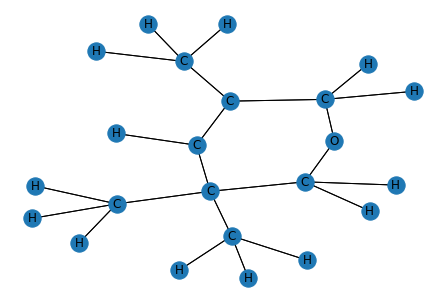

In [14]:
G = molecule_graphs[0]

pos = nx.kamada_kawai_layout(G)
atom_symbols = nx.get_node_attributes(G, 'atom_symbol')
edge_attributes = nx.get_edge_attributes(G, 'dist_atoms')
edges = G.edges()
nx.draw(G, pos, labels = atom_symbols,edges = edges, width = 1)
nx.draw_networkx_edges(G, pos, labels = edge_attributes)

Reading specific heat capacity for molecules

In [3]:
path = '/home/dionizije/Downloads/dsgdb9/'
heat_capacity_unit = 'cal/(molK)' #heat capacity at 298.15K
molecule_data = []
for molecule_graph in tqdm(molecule_graphs):
    name = molecule_graph.graph['name']
    with open(path + name + '.xyz') as file:
        data = file.readlines()[1]
        data = data.split()
        name_tag = data[0] + data[1]
        heat_capacity_cv = data[-1] #heat capacity at last position, according to readme
        dictionary = {'name': name_tag,
                      'heat_capacity_cv': heat_capacity_cv}
        molecule_data.append(dictionary)

target = pd.DataFrame.from_records(molecule_data, index = 'name')

100%|██████████| 84747/84747 [00:37<00:00, 2288.80it/s]


In [16]:
target

,heat_capacity_cv
name,
gdb74280,37.386
gdb44187,30.009
gdb87142,38.695
gdb75126,30.296
gdb5054,22.542
...,...
gdb52242,32.362
gdb14638,29.139
gdb12017,33.461


Testing if the data is ordered properly.

In [30]:
print(target.iloc[0])
print(molecule_graphs[0].graph)

heat_capacity_cv    37.386
Name: gdb74280, dtype: object
{'name': 'dsgdb9nsd_074280'}


## Initializing the network

In [5]:
adjacency_matrix,\
node_attributes,\
edge_attributes = spek.utils.nx_to_numpy(molecule_graphs, 
                                          auto_pad = True, 
                                          self_loops = False,
                                          nf_keys = ['atomic_num',
                                                     'atom_degree',
                                                     'atom_formal_charge',
                                                     'atom_hybridization'],
                                          ef_keys = ['dist_atoms', 
                                                     'bond_type'])

In [53]:
print(node_attributes.shape)
N = node_attributes.shape[1] #number of nodes --> padded to max number of atoms
F = node_attributes.shape[2]

(84747, 29, 4)


In [54]:
print(edge_attributes.shape)
S = edge_attributes.shape[-1]

(84747, 29, 29, 2)


In [55]:
print(target.shape)
target_shape = target.shape[-1]

(84747, 1)


Train test split

In [6]:
A_train, A_test, X_train, X_test,\
E_train, E_test, y_train, y_test = train_test_split(adjacency_matrix,
                                                    node_attributes,
                                                    edge_attributes,
                                                    target, random_state = 0)

### Model

In [57]:
# input layer
X_input = Input(shape = (N, F))
A_input = Input(shape = (N, N))
E_input = Input(shape = (N, N, S))

W0922 13:15:03.081300 140647779903296 deprecation_wrapper.py:119] From /home/dionizije/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 13:15:03.187721 140647779903296 deprecation_wrapper.py:119] From /home/dionizije/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [ ]:
graph_convolution_1 = EdgeConditionedConv(32, activation = 'relu')([X_input, A_input, E_input])
graph_convolution_2 = EdgeConditionedConv(64, activation = 'relu')([graph_convolution_1, A_input, E_input])
pooling_layer = GlobalAttentionPool(128)(graph_convolution_2)
dense_layer = Dense(128, activation = 'relu')(pooling_layer)
output_layer = Dense(target_shape)(dense_layer)

In [ ]:
model = Model(inputs = [X_input, A_input, E_input], outputs = output_layer)
optimizer = Adam()
model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae', 'mse'])

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

In [ ]:
history = model.fit([X_train, A_train, E_train], y_train, validation_split = 0.1,
          epochs = 50)

In [38]:
history = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Graph CNN/history.csv', index_col = 0)

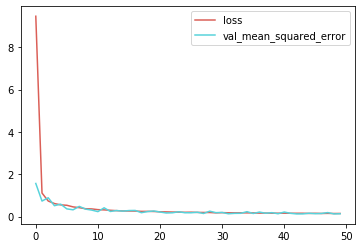

In [48]:
sns.lineplot(data = [history['loss'], history['val_mean_squared_error']],
             palette=sns.color_palette("hls", 2), dashes = False)

In [ ]:
y_pred = model.predict([X_test, A_test, E_test])

In [7]:
y_pred = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Graph CNN/y_pred.csv',
                    header = None)

In [8]:
print(mean_absolute_error(y_test, y_pred))

0.2930159470823781
